## Import libraries

In [1]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#%matplotlib inline
#from IPython.display import SVG, Markdown, display, display_pretty
#pd.set_option('display.max_columns', None)
#from sklearn.model_selection import KFold, train_test_split

In [15]:
from data import *
from transfer_learning import *
from test_functions import *
from layers import *
from utils import *
from loss import *
from metric import *
from results import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [16]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Reference model

In [17]:
df_microbioma_train, df_microbioma_test, _, _, \
df_domain_train, df_domain_test, _, _, otu_columns, domain_columns = \
    read_df_with_transfer_learning_subset_fewerDomainFeatures(['age','Temperature','Precipitation3Days'])

In [18]:
data_microbioma_train = df_microbioma_train.to_numpy(dtype=np.float32)
data_microbioma_test = df_microbioma_test.to_numpy(dtype=np.float32)
data_domain_train = df_domain_train.to_numpy(dtype=np.float32)
data_domain_test = df_domain_test.to_numpy(dtype=np.float32)

In [19]:
data_microbioma_train[:425].shape

(425, 717)

| Parameter             | Value         |
|:----------------------|:--------------|
| Input transform | Percentage |
| Output transform | Softmax |
| Reconstruction Loss | LossBrayCurtis |
| Latent Space | 10 |
| Bioma Autoencoder | b -> 512 -> 256 -> 10 -> 256 -> 512 -> b |
| Domain Autoencoder |   |
| Activation Encoder | tanh |
| Activation Decoder | tanh |
| Activation Latent | tanh |
| CV folds | 0 |
| Epochs | 100 |
| Batch Size | 64 |
| Learning Rate Scheduler | none |
| Learning Rate | constant = 0.001 |
| Optimizer | Adam |


<p>Best iteration: <b>93</b></p>

<b>loss</b>: 0.2008 (min: 0.2008, max: 0.2008)

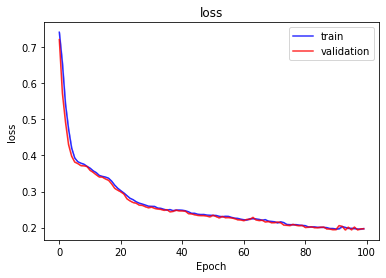

<b>bioma_mse</b>: 0.0000 (min: 0.0000, max: 0.0000)

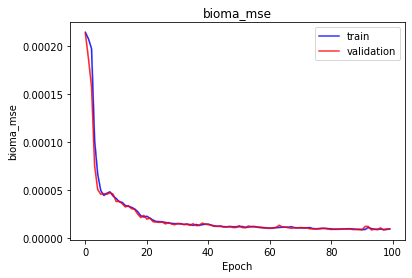

<b>bioma_mae</b>: 0.0006 (min: 0.0006, max: 0.0006)

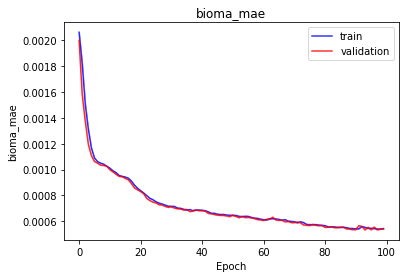

<b>bioma_mape</b>: 4860.5894 (min: 4860.5894, max: 4860.5894)

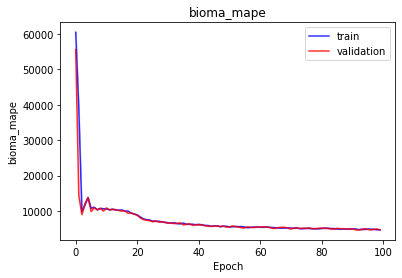

<b>bioma_BrayCurtis</b>: 0.2008 (min: 0.2008, max: 0.2008)

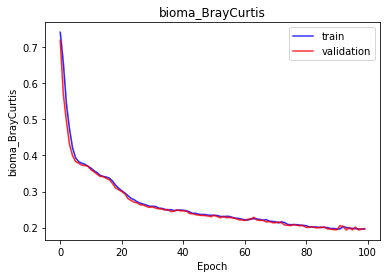

<b>bioma_pearson_corr</b>: 0.9281 (min: 0.9281, max: 0.9281)

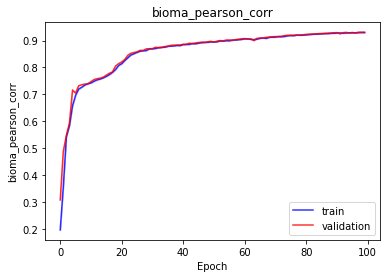

<b>bioma_jensen_shannon_divergence</b>: 0.3447 (min: 0.3447, max: 0.3447)

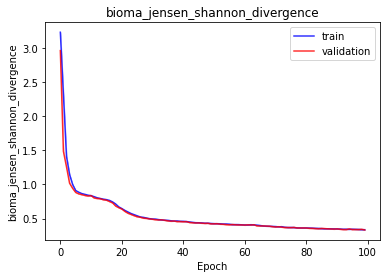

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.20078675143858965 | 0.20078675143858965 | 0.20078675143858965 |
| bioma_mse | 9.75824241322698e-06 | 9.75824241322698e-06 | 9.75824241322698e-06 |
| bioma_mae | 0.0005537196411751211 | 0.0005537196411751211 | 0.0005537196411751211 |
| bioma_mape | 4860.58935546875 | 4860.58935546875 | 4860.58935546875 |
| bioma_BrayCurtis | 0.2007867395877838 | 0.2007867395877838 | 0.2007867395877838 |
| bioma_pearson_corr | 0.928132176399231 | 0.928132176399231 | 0.928132176399231 |
| bioma_jensen_shannon_divergence | 0.34470027685165405 | 0.34470027685165405 | 0.34470027685165405 |


*************

In [20]:
# Train the selected model (the best one from those with the smallest latent space (10)): no.351
experiment_metrics, models, results = perform_experiment_2(cv_folds=0, 
                        epochs=100, 
                        batch_size=64, 
                        learning_rate=0.001, 
                        optimizer=optimizers.Adam,
                        learning_rate_scheduler=None,
                        input_transform=Percentage,
                        output_transform=tf.keras.layers.Softmax,
                        reconstruction_loss=MakeLoss(LossBrayCurtis, Percentage, None), 
                        latent_space=10, 
                        layers=[512,256],
                        activation='tanh', 
                        activation_latent='tanh', 
                        data_microbioma_train=data_microbioma_train[:425],
                        data_domain_train=None,
                        show_results=True, 
                        device='/CPU:0')

### To get encoders and decoders to use in domain->latent model

In [8]:
model, encoder, _ ,decoder = models[0]

In [21]:
df_domain_train[:425].shape

(425, 3)

### To predict latent space for samples in domain->latent model

In [22]:
latent_train = encoder.predict(data_microbioma_train[:425])
latent_test = encoder.predict(data_microbioma_test)

### To build model to predict latent space 

In [23]:
def model_fn_latent():
    in_layer = layers.Input(shape=(3,))
    net = layers.Dense(128, activation='tanh')(in_layer)
    net = layers.Dense(64, activation='tanh')(net)
    net = layers.Dense(32, activation='tanh')(net)
    net = layers.Dense(16, activation='tanh')(net)
    out_layer = layers.Dense(latent_train.shape[1], activation=None)(net) # 'tanh already'
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [24]:
result_latent, model_latent = train_tl_noEnsemble(model_fn_latent,
                            latent_train,
                            latent_train,
                            data_domain_train[:425],
                            data_domain_train[:425],
                            epochs=100,
                            batch_size=16,
                            verbose=-1)

In [25]:
predictions = test_model_tl_noEnsemble(model_latent, decoder, Percentage, tf.keras.layers.Softmax, data_microbioma_test, data_domain_test)

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.41293370723724365 | 0.41293370723724365 | 0.41293370723724365 |
| pearson_corr | 0.7293534278869629 | 0.7293534278869629 | 0.7293534278869629 |
| jensen_shannon_divergence | 0.8485406637191772 | 0.8485406637191772 | 0.8485406637191772 |
